In [2]:
import Pkg; Pkg.activate(joinpath(@__DIR__, "..")); Pkg.instantiate();
using Altro
using TrajectoryOptimization
using RobotDynamics
using StaticArrays
using LinearAlgebra

  Activating environment at `~/.julia/dev/AltroTutorials/Project.toml`
Precompiling project...
  ✓ Altro
  ✓ AltroTutorials
2 dependencies successfully precompiled in 6 seconds (184 already precompiled)


# Quadrotor: Rigid Bodies
Altro.jl, TrajectoryOptimization.jl, and RobotDynamics.jl are especially well-suited to solving problems for single rigid bodies subject to arbitrary forces and torques. These system are unique in that their state is parameterized by non-Euclidean 3D rotation, whose unique group structure requires special consideration during the optimization process. The TrajectoryOptimization.jl ecosystem provides a convenient API for working with these systems, and powerful and efficient methods for correctly optimizing the state and control trajectories for them. 

In this example we'll work on setting up simple zig-zag trajectory for a quadrotor.

## 1. Defining the Dynamics
Defining the dynamics for a single rigid body is slightly different than the generic case we've seen so far, since RobotDynamics.jl already defines the dynamics, so all we need to do is define the forces and torques that act on the body as a function of the state and control. Let's do this for the quadrotor. We start by defining our model struct:

In [3]:
struct Quadrotor{R} <: RobotDynamics.RigidBody{R}
    mass::Float64
    J::Diagonal{Float64,SVector{3,Float64}}
    Jinv::Diagonal{Float64,SVector{3,Float64}}
    gravity::SVector{3,Float64}
    motor_dist::Float64
    kf::Float64
    km::Float64
    bodyframe::Bool  # velocity in body frame?
    ned::Bool
end

# NOTE: no need to define the state dimension since that's already defined by RigidBody!
#       Do NOT override the state dimension since it's dependent on the rotation representation used
RobotDynamics.control_dim(::Quadrotor) = 4

This is almost the same as before, but now we're inheriting from `RobotDynamics.RigidBody`, which has a type parameter `R`, which tells us what rotation representation is being used. There are many ways of parameterizing 3D rotations, including rotation matrices, unit quaternions, Euler angles, or Rodrigues parameters, to name a few. Many of these representations are implemented in [Rotations.jl](https://github.com/JuliaGeometry/Rotations.jl). `RigidBody` expects this type to be a sub-type of `Rotations.Rotation{3,T}`. For those coming from C++ and familiar with templates, you can think of a parameterized type in a very similar way. The type parameter complicates defining the constructor a little, but the following form should always work well:

In [4]:
using Rotations

function Quadrotor{R}(;
        mass=0.5,
        J=Diagonal(@SVector [0.0023, 0.0023, 0.004]),
        gravity=SVector(0,0,-9.81),
        motor_dist=0.1750,
        kf=1.0,
        km=0.0245,
        bodyframe=false,
        ned=false,
    ) where R
    Quadrotor{R}(mass,J,inv(J),gravity,motor_dist,kf,km,bodyframe,ned)
end

# Define the default to `UnitQuaternion`
(::Type{Quadrotor})(;kwargs...) = Quadrotor{UnitQuaternion}(;kwargs...)

The first defines all our default values, and is called as `Quadrotor{UnitQuaterion}(...)`. Note that it's usually best to leave the scalar type parameter out of the rotation, since it allows for more generic conversions. The second constructor defines calls of the form `Quadrotor(...)` with no type parameter, so we call the first with our default type parameter, `UnitQuaternion`.

With our constructors defined, we're now ready to define the forces and moments acting on our quadrotor. These are defined in the following frames:
* Forces = **global** frame
* Moments = **local** (or body) frame

For convenience, we also define the function `trim_controls` to define the forces that maintain steady, level flight.

In [5]:
# Forces in the world frame: a sum of the motor forces along the z-axis of the quadrotor, along with gravity
function RobotDynamics.forces(model::Quadrotor, x, u)
    q = orientation(model, x)
    kf = model.kf
    g = model.gravity
    m = model.mass

    w1 = u[1]
    w2 = u[2]
    w3 = u[3]
    w4 = u[4]

    F1 = max(0,kf*w1);
    F2 = max(0,kf*w2);
    F3 = max(0,kf*w3);
    F4 = max(0,kf*w4);
    F = @SVector [0., 0., F1+F2+F3+F4] #total rotor force in body frame

    f = m*g + q*F # forces in world frame
    return f
end

# Moments in the body frame: account for moment arms and torque from spinning the props.
function RobotDynamics.moments(model::Quadrotor, x, u)

    kf, km = model.kf, model.km
    L = model.motor_dist

    w1 = u[1]
    w2 = u[2]
    w3 = u[3]
    w4 = u[4]

    F1 = max(0,kf*w1);
    F2 = max(0,kf*w2);
    F3 = max(0,kf*w3);
    F4 = max(0,kf*w4);

    M1 = km*w1;
    M2 = km*w2;
    M3 = km*w3;
    M4 = km*w4;
    tau = @SVector [L*(F2-F4), L*(F3-F1), (M1-M2+M3-M4)] #total rotor torque in body frame
    return tau
end

function trim_controls(model::Quadrotor)
    @SVector fill(-model.gravity[3]*model.mass/4.0, size(model)[2])
end

RobotDynamics.mass(model::Quadrotor) = model.mass
RobotDynamics.inertia(model::Quadrotor) = model.J

Now let's test our dynamics to make sure they work. Let's plug in trim conditions to make sure we get a time-derivative of zero. We'll use the overloaded `zeros` function on `RigidBody` to generate the "zero" or "identity" state vector for our model.

**NOTE**: We can also use `rand` to generate a random state and control vector. For rotations, this is correctly sampled from a uniform distribution over the space of rotations.

In [6]:
model = Quadrotor()

# Get a vector of zeros, and an identity rotation. The index pulls out the state, since it returns both a zero state and control
x = zeros(model)[1]

# Get the controls to hold level flight
u = trim_controls(model)

# Test with level flight. Time derivative should be zeros
dynamics(model, x, u)

13-element SVector{13, Float64} with indices SOneTo(13):
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

## 2. Define the Cost Function
In this problem we'll get a little more creative with our cost function. Since we want it to do a zig-zag pattern, we'll use a "waypoint" style cost function that has a nominal cost for most of the trajectory, with a couple "waypoint" costs at specific knot points with high cost for being far from a particular position. 

Since it's often useful to specify the costs on the position, orientation, and linear and angular velocities separate, RobotDynamics provides a few methods for building vectors from these 4 components, as long as you're working with a sub-type of `RigidBody`. As before, we start off with defining our discretizing and extracting our state and control dimensions out of our model.

In [7]:
# discretization
n,m = size(model)
N = 101 # number of knot points
tf = 5.0
dt = tf/(N-1) # total time

0.05

Next we define our "nominal" cost, which penalizes deviations from our nominal state. Note that we place a very lost cost on position and orientation, so we're really just encouraging it to have low linear and angular velocities. Also note that we use [`TrajectoryOptimization.QuatLQRCost`](http://roboticexplorationlab.org/TrajectoryOptimization.jl/dev/rotations.html#TrajectoryOptimization.QuatLQRCost) instead of `LQRCost`. This cost is very similar, but for sub-types of `RigidBody` it uses a more correct method for penalizing the distance between two rotations, using the geodesic distance. See the [documentation](http://roboticexplorationlab.org/TrajectoryOptimization.jl/dev/rotations.html#TrajectoryOptimization.QuatLQRCost) for more information.

In [8]:
Q_diag = RobotDynamics.fill_state(model, 1e-5, 0.0, 1e-3, 1e-3)  # build a vector from 4 scalars, one for position, orientation, and linear and angular velocities
Q = Diagonal(Q_diag)
R = Diagonal(@SVector fill(1e-4,m))
q_nom = UnitQuaternion(I)  # shortcut for identity rotation
v_nom, ω_nom = zeros(3), zeros(3)  # nominal linear and angular velocities
x_nom = RobotDynamics.build_state(model, zeros(3), q_nom, v_nom, ω_nom)  # build the nominal state vector

cost_nom = TrajectoryOptimization.QuatLQRCost(Q, R, x_nom, w=0.0);

Now we define our waypoint costs. We first define the waypoint locations and which time steps they correpond to. Then we define separate cost weights for the intermediate and terminal waypoints. These are then used to create a vector of cost functions.

In [9]:
wpts = [(@SVector [10,0,1.]),
                (@SVector [-10,0,1.]),
                (@SVector [0,10,1.])]
times = [33, 66, 101]
Qw_diag = RobotDynamics.fill_state(model, 1e3, 0, 1, 1)
Qf_diag = RobotDynamics.fill_state(model, 10., 0, 10, 10)

costs = map(1:length(wpts)) do i
    r = wpts[i]
    if times[i] == N
        Q = Diagonal(Qf_diag)
        w = 40.0
    else
        Q = Diagonal(1e-3*Qw_diag)
        w = 0.1
    end
    xg = RobotDynamics.build_state(model, r, q_nom, v_nom, ω_nom)
    TrajectoryOptimization.QuatLQRCost(Q, R, xg, w=w)
end;

With those cost functions all defined, we now define our objective by putting them all together:

In [10]:
costs_all = map(1:N) do k
    if k ∈ times  # test if it's a waypoint time step
        i = findfirst(x->(x ≥ k), times)
        costs[i]
    else          # use nominal cost otherwise
        cost_nom
    end
end

obj = Objective(costs_all)

Objective

## 3. Add Constraints
We'll add a simple bound to the control values to keep them positive and below a maximum thrust value

In [11]:
conSet = ConstraintList(n,m,N)
bnd = BoundConstraint(n,m, u_min=0.0, u_max=12.0)
add_constraint!(conSet, bnd, 1:N-1)

## 4. Setting up and Solving the Problem
From here, we set up and solve the problem following the same procedure we used before. Remember to provide a good initial guess, which in this case will be a hover trajectory.

In [12]:
# Initialization
u0 = @SVector fill(0.5*9.81/4, m)
U_hover = [copy(u0) for k = 1:N-1] # initial hovering control trajectory

# Initial and Final Condition
x0_pos = @SVector [0., -10., 1.]
x0 = RobotDynamics.build_state(model, x0_pos, UnitQuaternion(I), zeros(3), zeros(3))
xf = RobotDynamics.build_state(model, wpts[end], UnitQuaternion(I), zeros(3), zeros(3))

# Problem
prob = Problem(model, obj, xf, tf, x0=x0, constraints=conSet)
initial_controls!(prob, U_hover)

# Solver
opts = SolverOptions(
    penalty_scaling=100.,
    penalty_initial=0.1,
)
solver = ALTROSolver(prob, opts);

In [13]:
solve!(solver);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 25
    Solve Time: 17402.618517 (ms)

  Covergence
    Terminal Cost: 0.5532311678473902
    Terminal dJ: -0.01108654763608763
    Terminal gradient: 0.035933302473246366
    Terminal constraint violation: 2.152515168329927e-7
    Solve Status: SOLVE_SUCCEEDED


## 5. Visualization
We'll now show how to visualize the results in a 3D environment. We'll use `TrajOptPlots`, one of the packages in the TrajectoryOptimization.jl ecosystem, along with MeshCat.jl. To avoid having to define our own visualization method here, we'll use the Quadrotor model from RobotZoo (which we could have also used to solve our problem instead of defining our own model). Details on importing your own meshes are given in the last section of this notebook.

In [14]:
using TrajOptPlots
using MeshCat
using RobotZoo

In [15]:
vis = Visualizer()
TrajOptPlots.set_mesh!(vis, RobotZoo.Quadrotor())
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/brian/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8700))

In [16]:
visualize!(vis, solver)

**TIP**: You can use the controls in the top-right corner of the visualizer to replay the animation, slow it down, pause it etc. You can even record it and save the captured frames to an mp4 using `MeshCat.convert_frames_to_video`. *Easter Egg*: In the animations panel, if you click in any variable box (like the time scale) and drag, it will change the number like a slider.

## 6. Tracking the Reference Trajectory
We often want to track the optimized trajectory to make it robust to model disturbances. Since ALTRO computes a locally-optimal feedback controller about the current trajectory, we can use these gains to track our trajectory. First, however, we'll create a new model that adds some random disturbances to our model.

### Adding Disturbances to our Model
To add disturbances, we just create a new model that contains our nominal model and then modify the dynamics as needed. We'll do this for a single rigid body:

In [17]:
struct RandomWrenches{L,R} <: RobotDynamics.RigidBody{R}
    model::L
    f_mag::Float64
    f_std::Float64
    t_mag::Float64
    t_std::Float64
    
    # Define an "inner" constructor to enforce that `model` has to be a RigidBody{R}
    function RandomWrenches(model::L, f_mag::Real=1, f_std::Real=0.1, t_mag::Real=0.1, t_std::Real=0.01) where {L<:RobotDynamics.RigidBody}
        R = RobotDynamics.rotation_type(model)  # get the rotation type out of the model
        new{L,R}(model, f_mag, f_std, t_mag, t_std)
    end
end

RobotDynamics.control_dim(model::RandomWrenches) = control_dim(model.model)

function RobotDynamics.forces(model::RandomWrenches, x, u)
    # Get the original forces from the model
    F = RobotDynamics.forces(model.model, x, u)
    
    # Add the random disturbance
    return F + (model.f_mag .+ (model.f_std * @SVector randn(3)))
end

function RobotDynamics.moments(model::RandomWrenches, x, u)
    # Get the original moments from the model
    tau = RobotDynamics.moments(model.model, x, u)
    
    # Add the random disturbance
    return tau + (model.t_mag .+ (model.t_std * @SVector randn(3)))
end

# Use the same inertial parameters as the original model
RobotDynamics.mass(model::RandomWrenches) = RobotDynamics.mass(model.model)
RobotDynamics.inertia(model::RandomWrenches) = RobotDynamics.inertia(model.model)

In [18]:
model_disturbed = RandomWrenches(model, 0.1,0.01, 0, 0);  # use small disturbances, only on the forces (can change this later after adding feedback)

### Simulate Open Loop
We now want to see what happens when we simulate our system forward now that we have some disturbances. We first extract out the trajectory from the solver, copy it, and then use the `rollout!` method in RobotDynamics to simulate it forward using a 4th order Runge-Kutta method. This will start at the initial state of the provided trajectory and then just apply the controls, overwriting the states in the process.

In [19]:
Z_openloop = copy(get_trajectory(solver))
RobotDynamics.rollout!(RK4, model_disturbed, Z_openloop)

Now that we have our trajectory, let's visualize it. We first use `traj2!` to view a planar version of the trajectory (top-down).

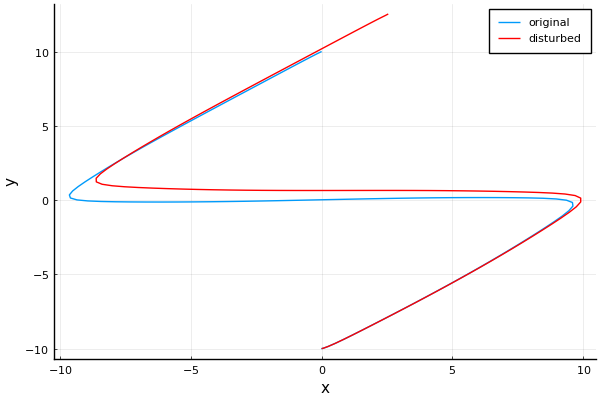

In [20]:
using Plots
pyplot()
traj2(states(solver), label="original")
traj2!(states(Z_openloop), label="disturbed", c=:red)

Now let's use MeshCat and TrajOptPlots to visualize and compare the 2 trajectories. Here we use a handy feature from TrajOptPlots that allows us to pass multiple trajectories to `visualize!` and it will visualize each one. We also use the [Colors.jl](https://github.com/JuliaGraphics/Colors.jl) package to specify the color of the disturbed quadrotor.

In [21]:
vis = Visualizer()
TrajOptPlots.set_mesh!(vis, RobotZoo.Quadrotor())
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat /home/brian/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8701))

In [22]:
using Colors
visualize!(vis, RobotZoo.Quadrotor(), get_trajectory(solver), Z_openloop, colors=[:default, colorant"red"])

### Simulating Closed Loop
Now that we see that the open-loop behavior is pretty far off, even with small disturbances, let's wrap it in the LQR controller provided by ALTRO. This is a pretty basic version, but it should get the idea across and show you how to extract the relevant information from the solver.

In [23]:
function sim_closed_loop(model, solver)
    # Get the gains out of the solver
    K = Altro.get_ilqr(solver).K
    d = Altro.get_ilqr(solver).d
    
    # Copy the trajectories
    Z = get_trajectory(solver)
    Xref = deepcopy(states(Z))
    Uref = deepcopy(controls(Z))
    
    # Initialize the new trajectories
    X = zero.(Xref)
    U = zero.(Uref)
    
    # Set the initial state
    X[1] = Xref[1]
    
    # Simulate the system forward
    for k = 1:length(Uref)
        dx = RobotDynamics.state_diff(model, X[k], Xref[k])
        X[k+1] = discrete_dynamics(RK4, model, X[k], Uref[k] + K[k]*dx + d[k], Z[k].t, Z[k].dt)
    end
    
    # Create a new trajectory with the new states and controls
    Znew = copy(Z)
    set_states!(Znew, X)
    set_controls!(Znew, U)
    return Znew
end
Z_cl = sim_closed_loop(model_disturbed, solver);

In [24]:
delete!(vis)
TrajOptPlots.set_mesh!(vis, RobotZoo.Quadrotor())
visualize!(vis, RobotZoo.Quadrotor(), get_trajectory(solver), Z_cl, colors=[:default, colorant"red"])
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot_copies" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot2" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), "robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set(Any[WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8701))

You should see dramatically better tracking performance! TrajOptPlots also allows us to visualize 3D lines, so let's plot the positions of each quadrotor in the visualize to compare them:

In [25]:
TrajOptPlots.traj3!(vis["original"], states(solver))
TrajOptPlots.traj3!(vis["disturbed"], states(Z_cl), color=colorant"red")

MeshCat Visualizer with path /meshcat/disturbed/traj at http://127.0.0.1:8701

## **(EXTRA)** Adding a Visualization method
To visualize our model we need to define some visualization methods. For a single rigid body, TrajOptPlots makes it pretty easy. We can easily scale objects in MeshCat by applying a simple scaling transformation using [CoordinateTransformations.jl](https://github.com/JuliaGeometry/CoordinateTransformations.jl).

In [60]:
using CoordinateTransformations
function TrajOptPlots._set_mesh!(vis, model::Quadrotor;
        scaling=1.0, color=colorant"black"
    )
    # path to mesh folder in TrajOptPlots
    urdf_folder = joinpath(dirname(pathof(TrajOptPlots)),"..","data","meshes")
    obj = joinpath(urdf_folder, "quadrotor_scaled.obj")
    
    # Load Mesh File
    robot_obj = MeshFileGeometry(obj)
    mat = MeshPhongMaterial(color=color)
    setobject!(vis["geom"], robot_obj, mat)
    settransform!(vis["geom"], LinearMap(I(3) * scaling))
end

In [61]:
# now we can call `set_mesh!` directly on our version of the Quadrotor
vis = Visualizer()
TrajOptPlots.set_mesh!(vis, model, scaling=1.0)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8707
└ @ MeshCat /home/brian/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8707))

In [62]:
visualize!(vis, solver)